In [19]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [20]:
# --- ARQUITECTURA DEL MODELO (copypaste de Leo) ---
class RedNeuronalGeneral(nn.Module):
    def __init__(self, input_shape, num_classes=3):
        super(RedNeuronalGeneral, self).__init__()
        self.input_dim = np.prod(input_shape)
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1), 
            nn.Dropout(0.3), 
            nn.Linear(256, 128), 
            nn.BatchNorm1d(128), 
            nn.LeakyReLU(0.1), 
            nn.Dropout(0.2), 
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [21]:
# --- DATASET CLASS ---
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convertir a PIL image si es numpy
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                # Normalizar a 0-255 si no lo está
                img = (img - img.min()) / (img.max() - img.min() + 1e-8) * 255
                img = img.astype(np.uint8)
            img_pil = Image.fromarray(img, mode='L')
        else:
            img_pil = img

        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor, label_tensor

In [22]:
# --- CARGA Y SUB-MUESTREO ---
LABEL_MAP = {1: 0, 2: 1, 3: 2} # Meningioma, Glioma, Pituitary
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']

def load_and_undersample_data(root_path, target_count=700):
    print("--- Cargando datos y aplicando Sub-muestreo Global ---")
    folder_map = {
        'Meningioma': 1,
        'Glioma': 2,
        'Adenoma_hipofisario': 3
    }

    # Estructura: class_id -> list of (patient_id, image, label)
    # Usaremos una lista plana temporal para hacer el subsampling global por clase
    class_data = defaultdict(list)

    for folder, label_orig in folder_map.items():
        path = os.path.join(root_path, folder)
        files = glob.glob(os.path.join(path, '*.npz'))
        
        print(f"Leyendo {folder}... ({len(files)} pacientes)")
        for f_path in files:
            try:
                # Extraer ID del paciente del nombre del archivo
                # formato esperado: patient_101017.npz o similar
                filename = os.path.basename(f_path)
                # Asumimos que el ID es todo lo que está entre 'patient_' y '.npz'
                patient_id = filename.replace('patient_', '').replace('paciente_', '').replace('.npz', '')
                
                data = np.load(f_path)
                # Cargar imágenes y MÁSCARAS
                imgs = data['imagenes'] if 'imagenes' in data else data['images']
                masks = data['mascaras'] if 'mascaras' in data else (data['masks'] if 'masks' in data else None)
                
                if masks is None:
                    print(f"Advertencia: No se encontraron máscaras en {filename}")
                    continue
                
                label_idx = LABEL_MAP[label_orig]
                
                for i in range(imgs.shape[0]):
                    img = imgs[i]
                    mask = masks[i]
                    
                    # Aplicar máscara: imagen * mask
                    # Asegurar dimensiones. Mask suele ser binaria (0, 1) o 0-255.
                    if mask.max() > 1:
                        mask = mask / 255.0
                        mask = (mask > 0.5).astype(np.float32)
                    
                    # Multiplicación elemento a elemento
                    masked_img = img * mask
                    
                    # Guardar tupla: (patient_id, imagen_procesada, label)
                    class_data[label_idx].append((patient_id, masked_img, label_idx))
                    
            except Exception as e:
                print(f"Error leyendo {f_path}: {e}")

    # --- SUB-MUESTREO --- 
    print("Conteos antes del sub-muestreo:")
    final_data_by_patient = defaultdict(lambda: {'images': [], 'labels': []})

    for class_idx in range(3):
        items = class_data[class_idx]
        count = len(items)
        print(f"  {CLASS_NAMES[class_idx]}: {count} cortes")
        
        if count > target_count:
            # Seleccionar aleatoriamente 'target_count' índices
            selected_items = random.sample(items, target_count)
        else:
            # Si hay menos o igual (caso Meningioma ~708 si target=700 es muy cerca, o si es menor)
            # El usuario pidió "todas en 700". Si Meningioma tiene 708, bajamos a 700.
            # Si alguna tuviera menos, tomamos todas.
            if count > target_count:
                 selected_items = random.sample(items, target_count)
            else:
                 selected_items = items # Mantener si es menor a target (o podríamos hacer oversampling aquí, pero pidieron sub-muestreo)
        
        # Reconstruir estructura por paciente para LOOCV
        for pid, img, lbl in selected_items:
            final_data_by_patient[pid]['images'].append(img)
            final_data_by_patient[pid]['labels'].append(lbl)

    print("Conteos DESPUÉS del sub-muestreo (Agrupados para LOOCV):")
    total_imgs = 0
    class_counts = {0: 0, 1: 0, 2: 0}
    for pid, data in final_data_by_patient.items():
        n = len(data['images'])
        total_imgs += n
        for l in data['labels']:
            class_counts[l] += 1
            
    for i in range(3):
        print(f"  {CLASS_NAMES[i]}: {class_counts[i]} cortes")
    print(f"Total pacientes: {len(final_data_by_patient)}")
    print(f"Total cortes: {total_imgs}")
    
    return final_data_by_patient

In [23]:
# --- LEAVE-ONE-PATIENT-OUT CROSS-VALIDATION ---
def run_loocv(data_by_patient, device, epochs=10):
    patient_ids = list(data_by_patient.keys())
    random.shuffle(patient_ids) # Mezclar orden de pacientes (opcional) 
    
    # Métricas globales
    global_true = []
    global_pred = []
    
    # Definir transformaciones
    train_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    
    num_patients = len(patient_ids)
    print(f"Iniciando LOOCV con {num_patients} iteraciones...")
    
    for i, test_pid in enumerate(patient_ids):
        # 1. Separar datos
        # Test: Paciente actual
        test_imgs = data_by_patient[test_pid]['images']
        test_lbls = data_by_patient[test_pid]['labels']
        
        if len(test_imgs) == 0: 
            continue # Saltar pacientes que se quedaron sin imagenes por el submuestreo

        # Train: Todos los demás
        train_imgs = []
        train_lbls = []
        for pid in patient_ids:
            if pid != test_pid:
                train_imgs.extend(data_by_patient[pid]['images'])
                train_lbls.extend(data_by_patient[pid]['labels'])
        
        # Crear Datasets
        train_ds = BrainTumorDataset(train_imgs, train_lbls, transform=train_transform)
        test_ds = BrainTumorDataset(test_imgs, test_lbls, transform=val_transform)
        
        # Crear DataLoaders
        # Usamos WeightedRandomSampler en el train interno para asegurar balance si quedó algo desbalanceado?
        # El usuario pidió sub-muestreo global a 700. Si hicimos eso, el dataset ya está balanceado globalmente.
        # Al quitar 1 paciente, el desbalance es mínimo. Podemos usar shuffle=True normal.
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
        
        # 2. Inicializar Modelo
        model = RedNeuronalGeneral(input_shape=(1, 64, 64), num_classes=3).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 3. Entrenar (Silencioso para no saturar output)
        model.train()
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 4. Evaluar en el paciente de prueba
        model.eval()
        patient_preds = []
        patient_true = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                patient_preds.extend(predicted.cpu().numpy())
                patient_true.extend(labels.cpu().numpy())
        
        # Acumular
        global_true.extend(patient_true)
        global_pred.extend(patient_preds)
        
        # Calcular acc del paciente actual para reporte de progreso
        if len(patient_true) > 0:
            acc = np.mean(np.array(patient_true) == np.array(patient_preds))
            print(f"Iteración {i+1}/{num_patients} (Paciente {test_pid}): Acc = {acc:.2f}")
        

    return global_true, global_pred


--- Cargando datos y aplicando Sub-muestreo Global ---
Leyendo Meningioma... (82 pacientes)
Leyendo Glioma... (89 pacientes)
Leyendo Adenoma_hipofisario... (62 pacientes)
Conteos antes del sub-muestreo:
  Meningioma: 708 cortes
  Glioma: 1426 cortes
  Pituitary: 930 cortes
Conteos DESPUÉS del sub-muestreo (Agrupados para LOOCV):
  Meningioma: 700 cortes
  Glioma: 700 cortes
  Pituitary: 700 cortes
Total pacientes: 229
Total cortes: 2100
Usando dispositivo: mps
Iniciando LOOCV con 229 iteraciones...
Iteración 1/229 (Paciente 100416): Acc = 0.00
Iteración 2/229 (Paciente 107495): Acc = 1.00
Iteración 3/229 (Paciente 104684): Acc = 0.83
Iteración 4/229 (Paciente MR051461): Acc = 0.50
Iteración 5/229 (Paciente 99308): Acc = 0.79
Iteración 6/229 (Paciente 111366): Acc = 0.58
Iteración 7/229 (Paciente MR048944B): Acc = 0.50
Iteración 8/229 (Paciente 97943): Acc = 0.93
Iteración 9/229 (Paciente MR048294B): Acc = 0.56
Iteración 10/229 (Paciente 107505): Acc = 1.00
Iteración 11/229 (Paciente MR

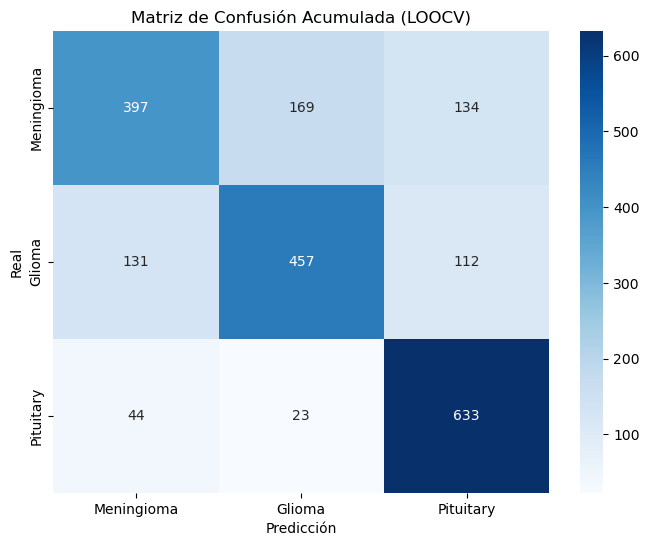

In [24]:
# --- EJECUCIÓN PRINCIPAL ---
PATH_PATIENT = 'Preprocesamiento_por_paciente'

if not os.path.exists(PATH_PATIENT):
    # Ajuste de ruta por si acaso
    PATH_PATIENT = 'Proyecto/Codigo/Preprocesamiento_por_paciente'

if os.path.exists(PATH_PATIENT):
    # 1. Cargar y sub-muestrear
    # Se solicitó ~700 imágenes por clase.
    data_dict = load_and_undersample_data(PATH_PATIENT, target_count=700)
    
    
    # 2. Configurar dispositivo
    #Para NVIDA CUDA
    if torch.cuda.is_available():
        device = 'cuda'
    #PARA mi MAC que no tiene CUDA :( 
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'

    print(f"Usando dispositivo: {device}")

    
    # 3. Correr LOOCV
    # epochs=10 es un buen balance para LOOCV (muchas iteraciones). 
    # En el notebook original usaban 15, podemos usar 10 o 15.
    y_true, y_pred = run_loocv(data_dict, device, epochs=10)
    
    # 4. Reporte Final
    print("--- RESULTADOS FINALES DE LOOCV ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    # Usamos seaborn si está instalado, sino matplotlib puro
    try:
        import seaborn as sns
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    except ImportError:
        plt.imshow(cm, cmap='Blues')
        plt.colorbar()
        # Annotations manuales si no hay seaborn
        for i in range(len(CLASS_NAMES)):
            for j in range(len(CLASS_NAMES)):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión Acumulada (LOOCV)')
    plt.show()
    
else:
    print(f"ERROR: No se encontró el directorio {PATH_PATIENT}")